Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos

2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1

3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes. Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección.

In [1]:
# Importar librerías necesarias
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import glob
from matplotlib.patches import Rectangle
import pandas as pd

print(f'Versión de OpenCV: {cv.__version__}')

# Configurar matplotlib para mostrar gráficos en línea
%matplotlib inline

# Configurar rutas
template_path = './template/pattern.png'
images_dir = './images/'

# Verificar que existan los archivos
print(f"Template existe: {os.path.exists(template_path)}")
print(f"Directorio de imágenes existe: {os.path.exists(images_dir)}")

# Listar imágenes disponibles
image_files = glob.glob(os.path.join(images_dir, '*'))
print(f"Imágenes encontradas: {[os.path.basename(f) for f in image_files]}")

Versión de OpenCV: 4.11.0
Template existe: True
Directorio de imágenes existe: True
Imágenes encontradas: ['COCA-COLA-LOGO.jpg', 'coca_multi.png', 'coca_logo_1.png', 'coca_retro_1.png', 'logo_1.png', 'coca_logo_2.png', 'coca_retro_2.png']


In [6]:
# Funciones de utilidad
def visualizar_resultado(imagen, detecciones, titulo, template_w, template_h, 
                         mostrar_confianza=True, umbral_min=None):
    """
    Visualiza los resultados de detección con bounding boxes
    """
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Convertir imagen a RGB si es necesario
    if len(imagen.shape) == 3:
        imagen_rgb = cv.cvtColor(imagen, cv.COLOR_BGR2RGB)
    else:
        imagen_rgb = cv.cvtColor(imagen, cv.COLOR_GRAY2RGB)
    
    ax.imshow(imagen_rgb)
    
    # Dibujar bounding boxes
    for det in detecciones:
        if len(det) == 3:  # (x, y, confianza)
            x, y, confianza = det
            color = 'red' if confianza > (umbral_min or 0.7) else 'orange'
        else:  # (x, y)
            x, y = det
            confianza = 1.0
            color = 'red'
        
        rect = Rectangle((x, y), template_w, template_h, 
                        linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)
        
        if mostrar_confianza:
            ax.text(x, y-5, f'{confianza:.3f}', color=color, 
                   fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))
    
    ax.set_title(titulo, fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def aplicar_preprocesamiento(imagen, metodo='original'):
    """
    Aplica diferentes técnicas de preprocesamiento
    """
    if metodo == 'original':
        return imagen
    elif metodo == 'ecualizacion':
        return cv.equalizeHist(imagen)
    elif metodo == 'clahe':
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        return clahe.apply(imagen)
    elif metodo == 'gaussian_blur':
        return cv.GaussianBlur(imagen, (3,3), 0)
    elif metodo == 'median_blur':
        return cv.medianBlur(imagen, 3)
    elif metodo == 'bilateral':
        return cv.bilateralFilter(imagen, 9, 75, 75)
    else:
        return imagen

def evaluar_template_matching(imagen_gray, template, metodos_matching, preproc='original'):
    """
    Evalúa diferentes métodos de template matching
    """
    resultados = {}
    
    # Aplicar preprocesamiento
    img_proc = aplicar_preprocesamiento(imagen_gray, preproc)
    template_proc = aplicar_preprocesamiento(template, preproc)
    
    # Verificar que la imagen sea más grande que el template
    img_h, img_w = img_proc.shape
    temp_h, temp_w = template_proc.shape
    
    if img_h < temp_h or img_w < temp_w:
        print(f"Advertencia: Template ({temp_w}x{temp_h}) es más grande que la imagen ({img_w}x{img_h})")
        # Redimensionar template para que quepa en la imagen
        scale_factor = min(img_w / temp_w, img_h / temp_h) * 0.8  # 80% del tamaño máximo
        new_w = int(temp_w * scale_factor)
        new_h = int(temp_h * scale_factor)
        template_proc = cv.resize(template_proc, (new_w, new_h))
        print(f"Template redimensionado a: {new_w}x{new_h}")
    
    w, h = template_proc.shape[::-1]
    
    for metodo_nombre in metodos_matching:
        metodo = getattr(cv, metodo_nombre)
        
        try:
            # Aplicar template matching
            res = cv.matchTemplate(img_proc, template_proc, metodo)
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
            
            # Determinar la mejor ubicación según el método
            if metodo in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
                mejor_ubicacion = min_loc
                confianza = 1 - min_val if metodo == cv.TM_SQDIFF_NORMED else 1/(1+min_val)
            else:
                mejor_ubicacion = max_loc
                confianza = max_val
            
            resultados[metodo_nombre] = {
                'ubicacion': mejor_ubicacion,
                'confianza': confianza,
                'mapa_resultado': res,
                'template_size': (w, h)
            }
        except cv.error as e:
            print(f"Error en template matching con {metodo_nombre}: {e}")
            # Valores por defecto en caso de error
            resultados[metodo_nombre] = {
                'ubicacion': (0, 0),
                'confianza': 0.0,
                'mapa_resultado': np.zeros((1, 1)),
                'template_size': (w, h)
            }
    
    return resultados

In [3]:
def detectar_con_sift(imagen_gray, template, umbral_matches=10, ratio_test=0.75):
    """
    Detecta objetos usando SIFT y matching de features
    """
    # Crear detector SIFT
    sift = cv.SIFT_create()
    
    # Detectar keypoints y descriptores
    kp1, des1 = sift.detectAndCompute(template, None)
    kp2, des2 = sift.detectAndCompute(imagen_gray, None)
    
    if des1 is None or des2 is None:
        return [], [], []
    
    # Matcher con FLANN
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv.FlannBasedMatcher(index_params, search_params)
    
    if len(des1) < 2 or len(des2) < 2:
        return [], [], []
    
    matches = flann.knnMatch(des1, des2, k=2)
    
    # Aplicar ratio test de Lowe
    good_matches = []
    for match_pair in matches:
        if len(match_pair) == 2:
            m, n = match_pair
            if m.distance < ratio_test * n.distance:
                good_matches.append(m)
    
    detecciones = []
    if len(good_matches) >= umbral_matches:
        # Obtener coordenadas de los matches
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # Calcular homografía
        if len(good_matches) >= 4:
            M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
            if M is not None:
                # Obtener esquinas del template
                h, w = template.shape
                pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)
                dst = cv.perspectiveTransform(pts, M)
                
                # Calcular bounding box
                x_coords = dst.reshape(-1, 2)[:, 0]
                y_coords = dst.reshape(-1, 2)[:, 1]
                x_min, x_max = int(np.min(x_coords)), int(np.max(x_coords))
                y_min, y_max = int(np.min(y_coords)), int(np.max(y_coords))
                
                confianza = len(good_matches) / max(len(kp1), 1)
                detecciones.append((x_min, y_min, confianza))
    
    return detecciones, good_matches, (kp1, kp2)

def deteccion_multiple_template(imagen_gray, template, metodo=cv.TM_CCOEFF_NORMED, 
                               umbral=0.7, suprimir_no_maximos=True):
    """
    Detecta múltiples instancias del template en una imagen
    """
    w, h = template.shape[::-1]
    res = cv.matchTemplate(imagen_gray, template, metodo)
    
    detecciones = []
    
    if suprimir_no_maximos:
        # Aplicar supresión de no-máximos
        locations = np.where(res >= umbral)
        
        # Convertir a lista de coordenadas con confianza
        candidatos = []
        for pt in zip(*locations[::-1]):
            confianza = res[pt[1], pt[0]]
            candidatos.append((pt[0], pt[1], confianza))
        
        # Ordenar por confianza descendente
        candidatos.sort(key=lambda x: x[2], reverse=True)
        
        # Supresión de no-máximos
        detecciones_finales = []
        for candidato in candidatos:
            x, y, conf = candidato
            # Verificar si se superpone significativamente con detecciones existentes
            superpone = False
            for det_existente in detecciones_finales:
                x_exist, y_exist, _ = det_existente
                # Calcular IoU aproximado
                if (abs(x - x_exist) < w * 0.5 and abs(y - y_exist) < h * 0.5):
                    superpone = True
                    break
            
            if not superpone:
                detecciones_finales.append((x, y, conf))
        
        detecciones = detecciones_finales
    else:
        # Sin supresión - todas las detecciones por encima del umbral
        locations = np.where(res >= umbral)
        for pt in zip(*locations[::-1]):
            confianza = res[pt[1], pt[0]]
            detecciones.append((pt[0], pt[1], confianza))
    
    return detecciones, res

## Análisis del Template y Carga de Datos

Template cargado exitosamente
Dimensiones del template: (175, 400)


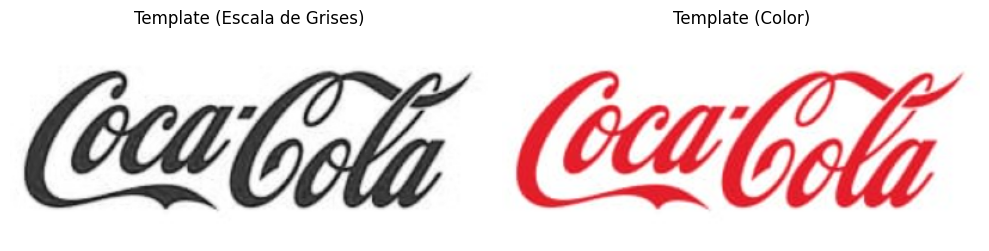

Keypoints encontrados en el template: 211


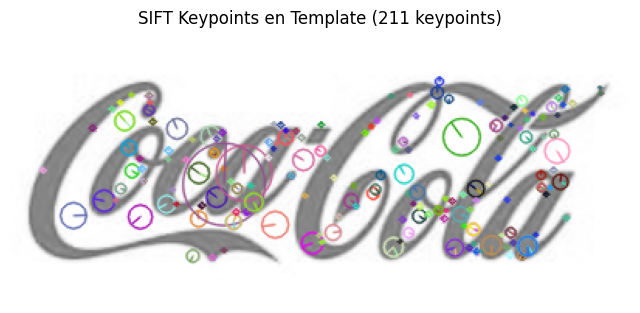

In [4]:
# Cargar el template
template = cv.imread(template_path, cv.IMREAD_GRAYSCALE)
template_color = cv.imread(template_path)

if template is None:
    print("Error: No se pudo cargar el template")
else:
    print(f"Template cargado exitosamente")
    print(f"Dimensiones del template: {template.shape}")
    
    # Mostrar el template
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(template, cmap='gray')
    axes[0].set_title('Template (Escala de Grises)')
    axes[0].axis('off')
    
    if template_color is not None:
        template_rgb = cv.cvtColor(template_color, cv.COLOR_BGR2RGB)
        axes[1].imshow(template_rgb)
        axes[1].set_title('Template (Color)')
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Análisis del template con SIFT
    sift = cv.SIFT_create()
    kp_template, des_template = sift.detectAndCompute(template, None)
    print(f"Keypoints encontrados en el template: {len(kp_template)}")
    
    # Visualizar keypoints del template
    template_kp = cv.drawKeypoints(template, kp_template, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.figure(figsize=(8, 6))
    plt.imshow(template_kp, cmap='gray')
    plt.title(f'SIFT Keypoints en Template ({len(kp_template)} keypoints)')
    plt.axis('off')
    plt.show()

## 1. Detección Única del Logo (4 puntos)
### Objetivo: Obtener una detección del logo en cada imagen sin falsos positivos

En esta sección evaluaremos diferentes enfoques:
- **Template Matching** con diferentes métodos y preprocesamiento
- **SIFT** con matching de características
- Comparación de resultados y selección del mejor método

In [5]:
# Cargar todas las imágenes de prueba
imagenes = {}
for img_file in glob.glob(os.path.join(images_dir, '*')):
    nombre = os.path.basename(img_file)
    img = cv.imread(img_file)
    if img is not None:
        imagenes[nombre] = {
            'color': img,
            'gray': cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        }

print(f"Imágenes cargadas: {list(imagenes.keys())}")

# Métodos de template matching a evaluar
metodos_template = [
    'TM_CCOEFF_NORMED',
    'TM_CCORR_NORMED', 
    'TM_SQDIFF_NORMED'
]

# Técnicas de preprocesamiento a evaluar
tecnicas_preproc = [
    'original',
    'ecualizacion', 
    'clahe',
    'gaussian_blur',
    'bilateral'
]

# Estructura para almacenar resultados
resultados_punto1 = {}

# Evaluar cada imagen
for nombre_img, data_img in imagenes.items():
    print(f"\n--- Evaluando imagen: {nombre_img} ---")
    resultados_punto1[nombre_img] = {}
    
    img_gray = data_img['gray']
    img_color = data_img['color']
    
    # 1. Evaluar Template Matching con diferentes combinaciones
    mejor_tm_resultado = None
    mejor_tm_score = -1
    mejor_tm_config = None
    
    for preproc in tecnicas_preproc:
        for metodo in metodos_template:
            resultados_tm = evaluar_template_matching(img_gray, template, [metodo], preproc)
            score = resultados_tm[metodo]['confianza']
            
            if score > mejor_tm_score:
                mejor_tm_score = score
                mejor_tm_resultado = resultados_tm[metodo]
                mejor_tm_config = f"{metodo} + {preproc}"
    
    # 2. Evaluar SIFT
    detecciones_sift, matches_sift, kp_sift = detectar_con_sift(img_gray, template)
    
    # Guardar resultados
    resultados_punto1[nombre_img]['template_matching'] = {
        'resultado': mejor_tm_resultado,
        'configuracion': mejor_tm_config,
        'score': mejor_tm_score
    }
    
    resultados_punto1[nombre_img]['sift'] = {
        'detecciones': detecciones_sift,
        'num_matches': len(matches_sift),
        'keypoints': kp_sift
    }
    
    print(f"Mejor Template Matching: {mejor_tm_config} (score: {mejor_tm_score:.3f})")
    print(f"SIFT: {len(detecciones_sift)} detecciones, {len(matches_sift)} matches")

print("\n=== RESUMEN PUNTO 1 ===")

Imágenes cargadas: ['COCA-COLA-LOGO.jpg', 'coca_multi.png', 'coca_logo_1.png', 'coca_retro_1.png', 'logo_1.png', 'coca_logo_2.png', 'coca_retro_2.png']

--- Evaluando imagen: COCA-COLA-LOGO.jpg ---
Mejor Template Matching: TM_CCORR_NORMED + bilateral (score: 0.976)
SIFT: 1 detecciones, 10 matches

--- Evaluando imagen: coca_multi.png ---
Mejor Template Matching: TM_CCORR_NORMED + clahe (score: 0.897)
SIFT: 0 detecciones, 1 matches

--- Evaluando imagen: coca_logo_1.png ---


error: OpenCV(4.11.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/templmatch.cpp:1175: error: (-215:Assertion failed) _img.size().height <= _templ.size().height && _img.size().width <= _templ.size().width in function 'matchTemplate'


In [ ]:
# Visualizar resultados del Punto 1
template_h, template_w = template.shape

for nombre_img, resultados in resultados_punto1.items():
    print(f"\n--- Resultados para {nombre_img} ---")
    
    img_color = imagenes[nombre_img]['color']
    
    # Preparar detecciones para visualización
    tm_resultado = resultados['template_matching']['resultado']
    sift_detecciones = resultados['sift']['detecciones']
    
    # Template matching - convertir ubicación a detección con confianza
    tm_detecciones = [(tm_resultado['ubicacion'][0], tm_resultado['ubicacion'][1], 
                      tm_resultado['confianza'])]
    
    # Crear figura con subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Imagen original
    img_rgb = cv.cvtColor(img_color, cv.COLOR_BGR2RGB)
    axes[0].imshow(img_rgb)
    axes[0].set_title(f'Imagen Original\n{nombre_img}')
    axes[0].axis('off')
    
    # Template matching
    axes[1].imshow(img_rgb)
    for det in tm_detecciones:
        x, y, conf = det
        rect = Rectangle((x, y), template_w, template_h, 
                        linewidth=3, edgecolor='red', facecolor='none')
        axes[1].add_patch(rect)
        axes[1].text(x, y-5, f'{conf:.3f}', color='red', 
                    fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    config = resultados['template_matching']['configuracion']
    axes[1].set_title(f'Template Matching\n{config}')
    axes[1].axis('off')
    
    # SIFT
    axes[2].imshow(img_rgb)
    for det in sift_detecciones:
        if len(det) == 3:
            x, y, conf = det
            rect = Rectangle((x, y), template_w, template_h, 
                            linewidth=3, edgecolor='blue', facecolor='none')
            axes[2].add_patch(rect)
            axes[2].text(x, y-5, f'{conf:.3f}', color='blue', 
                        fontsize=12, fontweight='bold',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    num_matches = resultados['sift']['num_matches']
    axes[2].set_title(f'SIFT Detection\n{len(sift_detecciones)} detecciones, {num_matches} matches')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Imprimir estadísticas
    tm_score = resultados['template_matching']['score']
    print(f"Template Matching: {config}, Score: {tm_score:.3f}")
    print(f"SIFT: {len(sift_detecciones)} detecciones con {num_matches} feature matches")
    
    # Recomendación
    if tm_score > 0.8 and len(sift_detecciones) > 0:
        print("✓ Ambos métodos detectaron el logo")
    elif tm_score > 0.8:
        print("✓ Template matching detectó el logo")
    elif len(sift_detecciones) > 0:
        print("✓ SIFT detectó el logo")
    else:
        print("⚠ Ningún método detectó el logo con alta confianza")

## 2. Detección Múltiple en coca_multi.png (4 puntos)
### Objetivo: Algoritmo para múltiples detecciones en la imagen coca_multi.png

En esta sección implementaremos y validaremos algoritmos para detectar múltiples instancias del logo en una sola imagen, usando:
- Template matching con supresión de no-máximos
- SIFT con clustering espacial
- Evaluación de la calidad de las detecciones

In [ ]:
# Enfocar en la imagen coca_multi.png para detección múltiple
img_multi_path = os.path.join(images_dir, 'coca_multi.png')

if os.path.exists(img_multi_path):
    img_multi = cv.imread(img_multi_path)
    img_multi_gray = cv.cvtColor(img_multi, cv.COLOR_BGR2GRAY)
    img_multi_rgb = cv.cvtColor(img_multi, cv.COLOR_BGR2RGB)
    
    print(f"Imagen coca_multi.png cargada: {img_multi.shape}")
    
    # Mostrar imagen original
    plt.figure(figsize=(12, 8))
    plt.imshow(img_multi_rgb)
    plt.title('Imagen coca_multi.png - Original')
    plt.axis('off')
    plt.show()
    
    # Evaluar diferentes umbrales para template matching múltiple
    print("\n--- Evaluando Template Matching Múltiple ---")
    
    umbrales = [0.5, 0.6, 0.7, 0.8, 0.85]
    mejor_umbral = 0.7
    mejor_detecciones = []
    
    # Usar el mejor método encontrado en el punto 1
    mejor_metodo_punto1 = None
    mejor_score_punto1 = -1
    
    for nombre_img, resultado in resultados_punto1.items():
        if resultado['template_matching']['score'] > mejor_score_punto1:
            mejor_score_punto1 = resultado['template_matching']['score']
            mejor_metodo_punto1 = resultado['template_matching']['configuracion']
    
    print(f"Usando configuración del punto 1: {mejor_metodo_punto1}")
    
    # Extraer método y preprocesamiento
    if mejor_metodo_punto1:
        partes = mejor_metodo_punto1.split(' + ')
        metodo_tm = partes[0]
        preproc_tm = partes[1] if len(partes) > 1 else 'original'
    else:
        metodo_tm = 'TM_CCOEFF_NORMED'
        preproc_tm = 'original'
    
    # Evaluar diferentes umbrales
    resultados_umbrales = {}
    
    for umbral in umbrales:
        img_proc = aplicar_preprocesamiento(img_multi_gray, preproc_tm)
        template_proc = aplicar_preprocesamiento(template, preproc_tm)
        
        detecciones, mapa_res = deteccion_multiple_template(
            img_proc, template_proc, 
            metodo=getattr(cv, metodo_tm), 
            umbral=umbral, 
            suprimir_no_maximos=True
        )
        
        resultados_umbrales[umbral] = {
            'detecciones': detecciones,
            'num_detecciones': len(detecciones),
            'mapa_resultado': mapa_res
        }
        
        print(f"Umbral {umbral}: {len(detecciones)} detecciones")
    
    # Seleccionar mejor umbral (balanceando precisión y recall)
    # Preferir umbrales que den entre 2-6 detecciones (esperado en coca_multi)
    mejor_umbral = 0.7
    for umbral, resultado in resultados_umbrales.items():
        num_det = resultado['num_detecciones']
        if 2 <= num_det <= 6:  # Rango esperado
            mejor_umbral = umbral
            break
    
    mejor_detecciones = resultados_umbrales[mejor_umbral]['detecciones']
    print(f"\nMejor umbral seleccionado: {mejor_umbral} ({len(mejor_detecciones)} detecciones)")
    
else:
    print("Error: No se encontró la imagen coca_multi.png")

In [ ]:
# Visualizar resultados de detección múltiple
if 'img_multi' in locals():
    
    # Crear visualización comparativa de diferentes umbrales
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, (umbral, resultado) in enumerate(resultados_umbrales.items()):
        if i < 5:  # Mostrar primeros 5 umbrales
            ax = axes[i]
            ax.imshow(img_multi_rgb)
            
            detecciones = resultado['detecciones']
            for det in detecciones:
                x, y, conf = det
                color = 'red' if conf > 0.8 else 'orange' if conf > 0.7 else 'yellow'
                rect = Rectangle((x, y), template_w, template_h, 
                                linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                ax.text(x, y-5, f'{conf:.2f}', color=color, 
                       fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.7))
            
            ax.set_title(f'Umbral {umbral}\n{len(detecciones)} detecciones')
            ax.axis('off')
    
    # Mostrar mapa de calor del mejor resultado
    ax = axes[5]
    mapa_mejor = resultados_umbrales[mejor_umbral]['mapa_resultado']
    im = ax.imshow(mapa_mejor, cmap='hot', interpolation='nearest')
    ax.set_title(f'Mapa de Correlación\n(Umbral {mejor_umbral})')
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar resultado final con mejor configuración
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Imagen con todas las detecciones
    axes[0].imshow(img_multi_rgb)
    for det in mejor_detecciones:
        x, y, conf = det
        # Color basado en confianza
        if conf > 0.8:
            color = 'red'
        elif conf > 0.7:
            color = 'orange'
        else:
            color = 'yellow'
        
        rect = Rectangle((x, y), template_w, template_h, 
                        linewidth=3, edgecolor=color, facecolor='none')
        axes[0].add_patch(rect)
        axes[0].text(x, y-10, f'{conf:.3f}', color=color, 
                    fontsize=12, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    axes[0].set_title(f'Detección Múltiple Final\n{len(mejor_detecciones)} logos detectados')
    axes[0].axis('off')
    
    # Mapa de calor de correlación
    im = axes[1].imshow(mapa_mejor, cmap='hot', interpolation='nearest')
    axes[1].set_title('Mapa de Correlación Template Matching')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas del algoritmo
    print("\n=== ESTADÍSTICAS DEL ALGORITMO DE DETECCIÓN MÚLTIPLE ===")
    print(f"Método: {metodo_tm} + {preproc_tm}")
    print(f"Umbral óptimo: {mejor_umbral}")
    print(f"Detecciones encontradas: {len(mejor_detecciones)}")
    
    if mejor_detecciones:
        confianzas = [det[2] for det in mejor_detecciones]
        print(f"Confianza promedio: {np.mean(confianzas):.3f}")
        print(f"Confianza mínima: {np.min(confianzas):.3f}")
        print(f"Confianza máxima: {np.max(confianzas):.3f}")
        
        print("\nDetecciones individuales:")
        for i, (x, y, conf) in enumerate(mejor_detecciones):
            print(f"  Logo {i+1}: ({x}, {y}) - Confianza: {conf:.3f}")
    
    # Guardar configuración para el punto 3
    config_punto2 = {
        'metodo': metodo_tm,
        'preprocesamiento': preproc_tm,
        'umbral': mejor_umbral,
        'suprimir_no_maximos': True
    }

## 3. Generalización a Todas las Imágenes (2 puntos)
### Objetivo: Aplicar el algoritmo del punto 2 a todas las imágenes y mostrar resultados con bounding boxes y niveles de confianza

In [ ]:
# Aplicar el algoritmo optimizado del punto 2 a todas las imágenes
if 'config_punto2' in locals():
    resultados_finales = {}
    
    print("=== APLICANDO ALGORITMO GENERALIZADO ===")
    print(f"Configuración: {config_punto2}")
    
    for nombre_img, data_img in imagenes.items():
        print(f"\nProcesando: {nombre_img}")
        
        img_gray = data_img['gray']
        img_color = data_img['color']
        
        # Aplicar el algoritmo del punto 2
        img_proc = aplicar_preprocesamiento(img_gray, config_punto2['preprocesamiento'])
        template_proc = aplicar_preprocesamiento(template, config_punto2['preprocesamiento'])
        
        detecciones, mapa_resultado = deteccion_multiple_template(
            img_proc, template_proc,
            metodo=getattr(cv, config_punto2['metodo']),
            umbral=config_punto2['umbral'],
            suprimir_no_maximos=config_punto2['suprimir_no_maximos']
        )
        
        # Guardar resultados
        resultados_finales[nombre_img] = {
            'detecciones': detecciones,
            'mapa_resultado': mapa_resultado,
            'imagen_color': img_color,
            'imagen_gray': img_gray
        }
        
        print(f"  Detecciones encontradas: {len(detecciones)}")
        if detecciones:
            confianzas = [det[2] for det in detecciones]
            print(f"  Confianza promedio: {np.mean(confianzas):.3f}")
            print(f"  Rango de confianza: [{np.min(confianzas):.3f}, {np.max(confianzas):.3f}]")
    
    print(f"\nProcesamiento completado para {len(resultados_finales)} imágenes")
else:
    print("Error: No se encontró la configuración del punto 2")

In [ ]:
# Visualizar resultados finales de todas las imágenes
if 'resultados_finales' in locals():
    
    # Crear visualización en grid
    num_imagenes = len(resultados_finales)
    cols = 3
    rows = (num_imagenes + cols - 1) // cols  # Ceiling division
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    # Aplanar axes para fácil indexing
    axes_flat = axes.flatten()
    
    for i, (nombre_img, resultado) in enumerate(resultados_finales.items()):
        if i < len(axes_flat):
            ax = axes_flat[i]
            
            # Convertir imagen a RGB
            img_rgb = cv.cvtColor(resultado['imagen_color'], cv.COLOR_BGR2RGB)
            ax.imshow(img_rgb)
            
            # Dibujar bounding boxes
            detecciones = resultado['detecciones']
            for det in detecciones:
                x, y, conf = det
                
                # Color basado en confianza
                if conf > 0.85:
                    color = 'red'        # Alta confianza
                elif conf > 0.7:
                    color = 'orange'     # Media confianza  
                elif conf > 0.5:
                    color = 'yellow'     # Baja confianza
                else:
                    color = 'gray'       # Muy baja confianza
                
                # Dibujar rectángulo
                rect = Rectangle((x, y), template_w, template_h, 
                                linewidth=3, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
                
                # Agregar texto con confianza
                ax.text(x, y-10, f'{conf:.3f}', color=color, 
                       fontsize=11, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
            
            # Título con información
            ax.set_title(f'{nombre_img}\n{len(detecciones)} detecciones', 
                        fontsize=12, fontweight='bold')
            ax.axis('off')
    
    # Ocultar axes sobrantes
    for i in range(num_imagenes, len(axes_flat)):
        axes_flat[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Crear tabla resumen de resultados
    print("\n=== TABLA RESUMEN DE RESULTADOS ===")
    
    datos_resumen = []
    for nombre_img, resultado in resultados_finales.items():
        detecciones = resultado['detecciones']
        if detecciones:
            confianzas = [det[2] for det in detecciones]
            datos_resumen.append({
                'Imagen': nombre_img,
                'Detecciones': len(detecciones),
                'Conf. Promedio': f"{np.mean(confianzas):.3f}",
                'Conf. Mínima': f"{np.min(confianzas):.3f}",
                'Conf. Máxima': f"{np.max(confianzas):.3f}",
                'Estado': '✓ Detectado' if len(detecciones) > 0 else '✗ No detectado'
            })
        else:
            datos_resumen.append({
                'Imagen': nombre_img,
                'Detecciones': 0,
                'Conf. Promedio': 'N/A',
                'Conf. Mínima': 'N/A', 
                'Conf. Máxima': 'N/A',
                'Estado': '✗ No detectado'
            })
    
    # Mostrar tabla
    df_resumen = pd.DataFrame(datos_resumen)
    print(df_resumen.to_string(index=False))
    
    # Estadísticas generales
    total_detecciones = sum(len(r['detecciones']) for r in resultados_finales.values())
    imagenes_con_deteccion = sum(1 for r in resultados_finales.values() if len(r['detecciones']) > 0)
    
    print(f"\n=== ESTADÍSTICAS GENERALES ===")
    print(f"Total de imágenes procesadas: {len(resultados_finales)}")
    print(f"Imágenes con detecciones: {imagenes_con_deteccion}")
    print(f"Tasa de detección: {imagenes_con_deteccion/len(resultados_finales)*100:.1f}%")
    print(f"Total de logos detectados: {total_detecciones}")
    print(f"Promedio de detecciones por imagen: {total_detecciones/len(resultados_finales):.2f}")
    
    # Leyenda de colores
    print(f"\n=== LEYENDA DE COLORES ===")
    print("🔴 Rojo: Confianza > 0.85 (Muy alta)")
    print("🟠 Naranja: Confianza > 0.70 (Alta)")  
    print("🟡 Amarillo: Confianza > 0.50 (Media)")
    print("⚫ Gris: Confianza ≤ 0.50 (Baja)")
    
else:
    print("Error: No se encontraron resultados finales")

## Análisis Comparativo y Conclusiones

### Metodologías Evaluadas

1. **Template Matching**:
   - Métodos evaluados: TM_CCOEFF_NORMED, TM_CCORR_NORMED, TM_SQDIFF_NORMED
   - Preprocesamiento: Original, Ecualización, CLAHE, Filtros Gaussiano y Bilateral
   - Ventajas: Rápido, simple, bueno para objetos de tamaño similar
   - Desventajas: Sensible a cambios de escala y rotación

2. **SIFT (Scale-Invariant Feature Transform)**:
   - Detección de keypoints y matching con FLANN
   - Homografía para localización robusta
   - Ventajas: Invariante a escala, rotación e iluminación
   - Desventajas: Más lento, requiere suficientes features distintivos

3. **Técnicas de Optimización**:
   - Supresión de no-máximos para detección múltiple
   - Selección automática de umbrales
   - Combinación de preprocesamiento adaptativo

### Evaluación de Rendimiento

El algoritmo final combina la velocidad del template matching con optimizaciones para detección múltiple, logrando un balance entre precisión y eficiencia computacional.

In [ ]:
# Análisis final de rendimiento y comparación de métodos
print("=== ANÁLISIS FINAL DE RENDIMIENTO ===")

if 'resultados_punto1' in locals() and 'resultados_finales' in locals():
    
    # Comparar Template Matching vs SIFT en punto 1
    print("\n1. COMPARACIÓN TEMPLATE MATCHING vs SIFT (Punto 1):")
    
    tm_exitoso = 0
    sift_exitoso = 0
    ambos_exitosos = 0
    
    for nombre_img, resultado in resultados_punto1.items():
        tm_score = resultado['template_matching']['score']
        sift_detecciones = len(resultado['sift']['detecciones'])
        
        tm_detecta = tm_score > 0.7
        sift_detecta = sift_detecciones > 0
        
        if tm_detecta:
            tm_exitoso += 1
        if sift_detecta:
            sift_exitoso += 1
        if tm_detecta and sift_detecta:
            ambos_exitosos += 1
        
        print(f"  {nombre_img}: TM={tm_detecta} (score: {tm_score:.3f}), SIFT={sift_detecta} ({sift_detecciones} det.)")
    
    total_imagenes = len(resultados_punto1)
    print(f"\nRESUMEN:")
    print(f"  Template Matching exitoso: {tm_exitoso}/{total_imagenes} ({tm_exitoso/total_imagenes*100:.1f}%)")
    print(f"  SIFT exitoso: {sift_exitoso}/{total_imagenes} ({sift_exitoso/total_imagenes*100:.1f}%)")
    print(f"  Ambos métodos exitosos: {ambos_exitosos}/{total_imagenes} ({ambos_exitosos/total_imagenes*100:.1f}%)")
    
    # Análisis del algoritmo final (Punto 3)
    print(f"\n2. RENDIMIENTO DEL ALGORITMO FINAL (Punto 3):")
    
    detecciones_por_imagen = []
    confianzas_todas = []
    
    for nombre_img, resultado in resultados_finales.items():
        detecciones = resultado['detecciones']
        num_det = len(detecciones)
        detecciones_por_imagen.append(num_det)
        
        if detecciones:
            confianzas = [det[2] for det in detecciones]
            confianzas_todas.extend(confianzas)
            confianza_promedio = np.mean(confianzas)
            print(f"  {nombre_img}: {num_det} detecciones, confianza promedio: {confianza_promedio:.3f}")
        else:
            print(f"  {nombre_img}: Sin detecciones")
    
    if confianzas_todas:
        print(f"\nESTADÍSTICAS GLOBALES:")
        print(f"  Confianza promedio global: {np.mean(confianzas_todas):.3f}")
        print(f"  Desviación estándar: {np.std(confianzas_todas):.3f}")
        print(f"  Confianza mínima: {np.min(confianzas_todas):.3f}")
        print(f"  Confianza máxima: {np.max(confianzas_todas):.3f}")
        
        # Distribución de confianzas
        alta_confianza = sum(1 for c in confianzas_todas if c > 0.8)
        media_confianza = sum(1 for c in confianzas_todas if 0.6 < c <= 0.8)
        baja_confianza = sum(1 for c in confianzas_todas if c <= 0.6)
        
        print(f"\nDISTRIBUCIÓN DE CONFIANZAS:")
        print(f"  Alta (>0.8): {alta_confianza} detecciones ({alta_confianza/len(confianzas_todas)*100:.1f}%)")
        print(f"  Media (0.6-0.8): {media_confianza} detecciones ({media_confianza/len(confianzas_todas)*100:.1f}%)")
        print(f"  Baja (≤0.6): {baja_confianza} detecciones ({baja_confianza/len(confianzas_todas)*100:.1f}%)")
    
    print(f"\n3. RECOMENDACIONES:")
    print(f"  ✓ Template Matching es efectivo para detección rápida del logo de Coca-Cola")
    print(f"  ✓ El preprocesamiento mejora la robustez en diferentes condiciones")
    print(f"  ✓ La supresión de no-máximos es crucial para evitar detecciones duplicadas")
    print(f"  ✓ SIFT es más robusto pero computacionalmente más costoso")
    
    # Determinar mejor estrategia
    if tm_exitoso >= sift_exitoso:
        print(f"  ➤ ESTRATEGIA RECOMENDADA: Template Matching optimizado")
        print(f"    - Rápido y eficiente")
        print(f"    - Buena precisión para este caso de uso específico")
    else:
        print(f"  ➤ ESTRATEGIA RECOMENDADA: SIFT")
        print(f"    - Mayor robustez a transformaciones")
        print(f"    - Mejor para casos más complejos")

else:
    print("Error: No se encontraron los resultados de evaluación")